# Tutorial 3: Simulation of a 3-nodes minimal network

## 1. Import dependencies and create functions

In [1]:
import numpy as np
from scipy.constants import bar, atm, zero_Celsius, pi, R, g

In [2]:
print(f"1 bar = {bar} Pa")
print(f"1 atm = {atm} Pa")
print(f"0 degree Celsius = {zero_Celsius} K")
print(f"The gas constant R is: {R} $J⋅K^(−1)⋅mol−1$")
print(f"standard acceleration of gravity: {g}")

1 bar = 100000.0 Pa
1 atm = 101325.0 Pa
0 degree Celsius = 273.15 K
The gas constant R is: 8.314462618 $J⋅K^(−1)⋅mol−1$
standard acceleration of gravity: 9.80665


In [3]:
# Define constant variables
T_ST = 15 + zero_Celsius  # standard temperature (15 degree celcius in K)
P_ST = 1 * atm  # standard pressure in Pa
T_ST, P_ST

(288.15, 101325.0)

In [4]:
# Natural gas properties
RD = 0.5809537044528823
Z = 0.8949986269945526
# Average molar mass of air
M_AIR = 28.97  # g/mol

In [5]:
# Determin the C1 and C2
C1 = pi * (R * 1000 / 16 / M_AIR)**0.5
C2 = 2 * g * M_AIR / (R * 1000)
C1, C2

(13.305546782440928, 0.06833842752145018)

In [6]:
# Function to determine the flow direction
def flow_direction(p1, p2, e):
    if (p1**2 - p2**2 - e) >= 0:
        return 1
    else:
        return -1

In [7]:
# Function to calculate the average temperature
def calculate_average_temperature(t1, t2):
    return (t1+t2) / 2

In [8]:
# Function to calculate the average pressure
def calculate_average_pressure(p1, p2):
    return 2/3 * ((p1+p2) - (p1*p2) / (p1 + p2))

In [9]:
# Function to calculate the height difference effect
def height_effect(h1, h2, p1, p2, t1, t2, d=RD, Z=Z):
    p_avg = calculate_average_pressure(p1, p2)
    t_avg = calculate_average_temperature(t1, t2)
    return C2 * d * (h2-h1) * p_avg**2 / (t_avg*Z)

In [10]:
# Create a helper function to calculate C_ij of a pipe which won't change during one iteration
def c_pipe(t1, t2, L, D, f=0.01, eta=0.85, Z=Z, d=RD):
    t_avg = calculate_average_temperature(t1, t2)
    return C1 * T_ST/P_ST * (D**2.5) * eta * (1 / (L*t_avg*f*d*Z))**0.5

In [11]:
def volumetric_flow_rate(p1, p2, t1, t2, h1, h2, L, D, d=RD, Z=Z, f=0.01, eta=0.85):
    # p_avg = calculate_average_pressure(p1, p2)
    t_avg = calculate_average_temperature(t1, t2)
    e = height_effect(h1, h2, p1, p2, t1, t2)
    f_direction = flow_direction(p1, p2, e)
    return f_direction * eta * C1 * T_ST/P_ST * (abs(p1**2 - p2**2 - e) / (L*d*t_avg*Z))**0.5 * D**2.5 / f**0.5

## 2. Simulation of a simple 3 nodes network using the Newton-Raphson algorithm

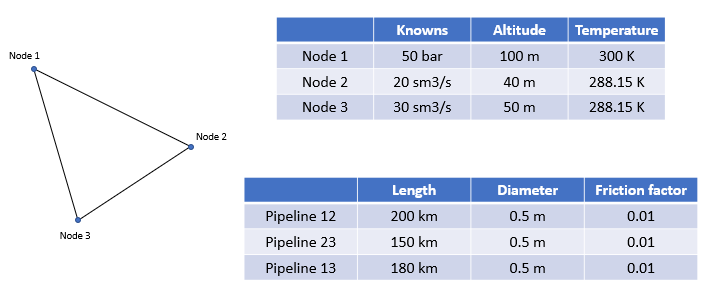

In [12]:
# Set up the known parameters & variables
p1 = 50 * bar # 50 bar
f_target = np.array([20., 30.])  # 20 sm3/s
# t1 = 300
t1 = 288.15
t2 = 288.15
t3 = 288.15
h1 = 100
h2 = 40
h3 = 50

In [13]:
# Initialization for the NR-solver
p2 = 0.98 * p1
p3 = 0.98 * p2
x0 = np.array([p2, p3])
x0

array([4900000., 4802000.])

### first iteration

In [14]:
q12 = volumetric_flow_rate(p1, p2, t1, t2, h1, h2, 200000, D=0.5)
q32 = volumetric_flow_rate(p3, p2, t3, t2, h3, h2, 150000, D=0.5)
d2 = q12 + q32
print(f'q12: {q12},\nq32: {q32},\nd2:{d2}.')

q12: 11.455115777937822,
q32: -11.46963306390318,
d2:-0.014517285965357729.


In [15]:
q13 = volumetric_flow_rate(p1, p3, t1, t3, h1, h3, 180000, D=0.5)
q23 = volumetric_flow_rate(p2, p3, t2, t3, h2, h3, 150000, D=0.5)
d3 = q13 + q23
print(f'q13: {q13},\nq23: {q23},\nd2:{d3}.')

q13: 15.962668223726697,
q23: 11.46963306390318,
d2:27.432301287629876.


In [16]:
c12 = c_pipe(300, 288.15, 200000, 0.5)
c23 = c_pipe(288.15, 288.15, 50000, 0.5)
c13 = c_pipe(300, 288.15, 180000, 0.5)
print(f'c12: {c12},\nc23: {c23},\nc13: {c13}.')

c12: 1.02814099590053e-05,
c23: 2.0773152674978277e-05,
c13: 1.0837557676131717e-05.


In [17]:
e12 = height_effect(h1, h2, p1, p2, t1, t2)
e23 = height_effect(h2, h3, p2, p3, t2, t3)
e13 = height_effect(h1, h3, p1, p3, t1, t3)
print(e12, e23, e13)

-226337597826.67294 36229104825.45612 -184936678890.09216


In [18]:
dq12_dp2 = c12 * p2 / (abs(p1**2 - p2**2 - e12))**0.5
print(dq12_dp2)
dq32_dp2 = c23 * p2 / (abs(p2**2 - p3**2 - e23))**0.5
print(dq32_dp2)
dq32_dp3 = c23 * (-p3) / (abs(p2**2 - p3**2 - e23))**0.5
print(dq32_dp3)
dq23_dp2 = c23 * (-p2) / (abs(p2**2 - p3**2 - e23))**0.5
print(dq23_dp2)
dq13_dp3 = c13 * p3 / (abs(p1**2 - p3**2 - e13))**0.5
print(dq13_dp3)
dq23_dp3 = c23 * p3 / (abs(p2**2 - p3**2 - e23))**0.5
print(dq23_dp3)

4.5679536740197346e-05
0.0001064365415441786
-0.000104307810713295
-0.0001064365415441786
3.569433152218366e-05
0.000104307810713295


In [19]:
j_mat = np.zeros((2, 2))
j_mat[0][0] = dq12_dp2 + dq32_dp2
j_mat[0][1] = dq32_dp3
j_mat[1][0] = dq23_dp2
j_mat[1][1] = dq13_dp3 + dq23_dp3
j_mat

array([[ 0.00015212, -0.00010431],
       [-0.00010644,  0.00014   ]])

In [20]:
j_mat_inv = np.linalg.inv(j_mat)
j_mat_inv

array([[13733.22090805, 10231.85919935],
       [10440.6726524 , 14921.51243823]])

In [21]:
d2 = q12 + q32
d3 = q13 + q23
f0 = np.array([d2, d3])
delta_f0 = f_target - f0
f0, delta_f0

(array([-1.45172860e-02,  2.74323013e+01]), array([20.01451729,  2.56769871]))

In [22]:
x1 = x0 - np.dot(j_mat_inv, delta_f0)
print(x1)

[4598863.88105247 4554721.02844717]


In [23]:
err = 1
tol = 0.01
x0 = np.array([49*bar, 49*0.98*bar])
p = x0
n_iter = 0
while err > tol:
    p2 = p[0]
    p3 = p[1]
    # F(X)
    q12 = volumetric_flow_rate(p1, p2, t1, t2, h1, h2, 200000, D=0.5)
    q32 = volumetric_flow_rate(p3, p2, t3, t2, h3, h2, 150000, D=0.5)
    q13 = volumetric_flow_rate(p1, p3, t1, t3, h1, h3, 180000, D=0.5)
    q23 = volumetric_flow_rate(p2, p3, t2, t3, h2, h3, 150000, D=0.5)
    
    # Jacobian matrix
    # c12 = c_pipe(300, 288.15, 200000, 0.5)
    # c23 = c_pipe(288.15, 288.15, 50000, 0.5)
    # c13 = c_pipe(300, 288.15, 180000, 0.5)
    e12 = height_effect(h1, h2, p1, p2, t1, t2)
    e23 = height_effect(h2, h3, p2, p3, t2, t3)
    e13 = height_effect(h1, h3, p1, p3, t1, t3)
    dq12_dp2 = c12 * p2 / (abs(p1**2 - p2**2 - e12))**0.5
    dq32_dp2 = c23 * p2 / (abs(p2**2 - p3**2 - e23))**0.5
    dq32_dp3 = c23 * (-p3) / (abs(p2**2 - p3**2 - e23))**0.5
    dq23_dp2 = c23 * (-p2) / (abs(p2**2 - p3**2 - e23))**0.5
    dq13_dp3 = c13 * p3 / (abs(p1**2 - p3**2 - e13))**0.5
    dq23_dp3 = c23 * p3 / (abs(p2**2 - p3**2 - e23))**0.5
    j_mat = np.zeros((2, 2))
    j_mat[0][0] = dq12_dp2 + dq32_dp2
    j_mat[0][1] = dq32_dp3
    j_mat[1][0] = dq23_dp2
    j_mat[1][1] = dq13_dp3 + dq23_dp3
    
    # Update unknown variables X
    j_mat_inv = np.linalg.inv(j_mat)
    d2 = q12 + q32
    d3 = q13 + q23
    f = np.array([d2, d3])
    delta_f = f_target - f
    print(f"The error after the iteration step {n_iter} is: {delta_f}")
    p = p - np.dot(j_mat_inv, delta_f)
    err = max(abs(delta_f))
    n_iter += 1
print(f'Simulation converges in {n_iter} iterations!')

The error after the iteration step 0 is: [20.01451729  2.56769871]
The error after the iteration step 1 is: [ 6.37589948 -0.35809604]
The error after the iteration step 2 is: [ 1.35591764 -0.94398366]
The error after the iteration step 3 is: [ 0.42567535 -0.42570808]
The error after the iteration step 4 is: [ 0.16627141 -0.16624277]
The error after the iteration step 5 is: [ 0.06657233 -0.06656545]
The error after the iteration step 6 is: [ 0.0269154  -0.02691317]
The error after the iteration step 7 is: [ 0.01092449 -0.01092367]
The error after the iteration step 8 is: [ 0.00444105 -0.00444073]
Simulation converges in 9 iterations!


In [24]:
p

array([4446893.35842759, 4429603.79400115])

In [25]:
f

array([19.99555895, 30.00444073])

In [26]:
p2 = p[0]
p3 = p[1]
q12 = volumetric_flow_rate(p1, p2, t1, t2, h1, h2, 200000, D=0.5)
q13 = volumetric_flow_rate(p1, p3, t1, t3, h1, h3, 180000, D=0.5)
q23 = volumetric_flow_rate(p2, p3, t2, t3, h2, h3, 150000, D=0.5)
q12, q13, q23

(24.206941063721285, 25.793058808002243, 4.2087476066797995)

## 3. Simulation of the same network using GasNetSim

In [27]:
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.constants import bar, zero_Celsius

import GasNetSim as gns
from GasNetSim import Node, Pipeline, Network

In [28]:
node1 = Node(node_index=1, pressure_pa=50*bar, altitude=100, node_type='reference')
node2 = Node(node_index=2, volumetric_flow=20, altitude=40, node_type='demand')
node3 = Node(node_index=3, volumetric_flow=30, altitude=50, node_type='demand')
nodes = {1: node1,
         2: node2,
         3: node3}

In [29]:
pipeline1 = Pipeline(inlet=node1, outlet=node2, diameter=0.5, length=200e3, friction_factor_method='constant', constant_friction_factor=0.01)
pipeline2 = Pipeline(inlet=node2, outlet=node3, diameter=0.5, length=150e3, friction_factor_method='constant', constant_friction_factor=0.01)
pipeline3 = Pipeline(inlet=node3, outlet=node1, diameter=0.5, length=180e3, friction_factor_method='constant', constant_friction_factor=0.01)
pipelines = {1: pipeline1,
             2: pipeline2,
             3: pipeline3}

In [30]:
network = Network(nodes, pipelines)

In [31]:
network.simulation(underrelaxation_factor=1)

INFO:root:Initial pressure: [5000000.         4833333.33333333 4624043.86075209]
INFO:root:Initial flow: [-50.  20.  30.]
INFO:GasNetSim.components.network:Simulation converges in 8 iterations.
INFO:GasNetSim.components.network:[5000000.         4446891.57188009 4429612.59874627]


In [32]:
[n.pressure for n in network.nodes.values()]

[5000000.0, 4446891.571880087, 4429612.598746273]

In [33]:
[p.flow_rate for p in network.pipelines.values()]

[24.207054242947077, 4.207054230332705, -25.79294576085184]